Loaded miles_dat.txt containing 128 cities.
Graph with 128 nodes and 8128 edges


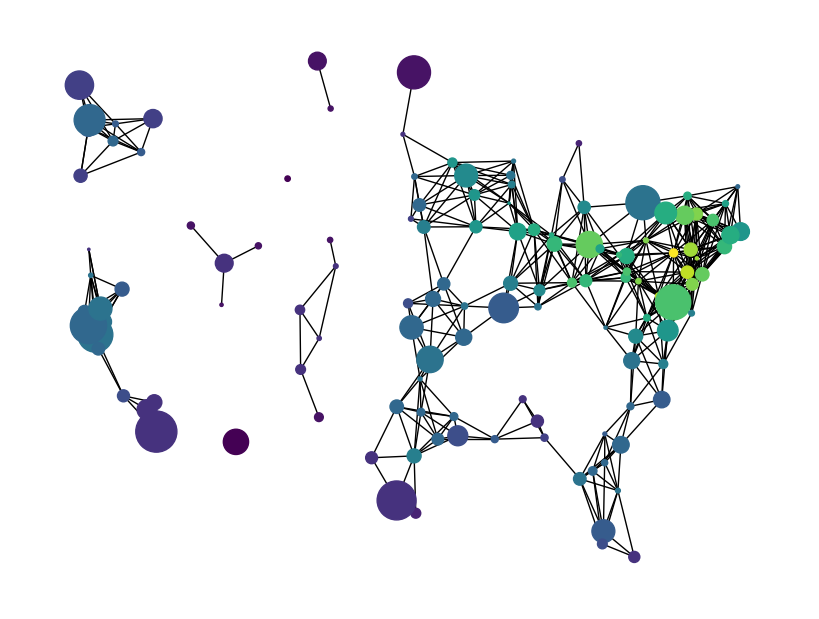

In [2]:
import gzip
import re

# Ignore any warnings related to downloading shpfiles with cartopy
import warnings

warnings.simplefilter("ignore")

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx


def miles_graph():
    """Return the cites example graph in miles_dat.txt
    from the Stanford GraphBase.
    """
    # open file miles_dat.txt.gz (or miles_dat.txt)

    fh = gzip.open("knuth_miles.txt.gz", "r")

    G = nx.Graph()
    G.position = {}
    G.population = {}

    cities = []
    for line in fh.readlines():
        line = line.decode()
        if line.startswith("*"):  # skip comments
            continue

        numfind = re.compile(r"^\d+")

        if numfind.match(line):  # this line is distances
            dist = line.split()
            for d in dist:
                G.add_edge(city, cities[i], weight=int(d))
                i = i + 1
        else:  # this line is a city, position, population
            i = 1
            (city, coordpop) = line.split("[")
            cities.insert(0, city)
            (coord, pop) = coordpop.split("]")
            (y, x) = coord.split(",")

            G.add_node(city)
            # assign position - Convert string to lat/long
            G.position[city] = (-float(x) / 100, float(y) / 100)
            G.population[city] = float(pop) / 1000
    return G


G = miles_graph()

print("Loaded miles_dat.txt containing 128 cities.")
print(G)

# make new graph of cites, edge if less then 300 miles between them
H = nx.Graph()
for v in G:
    H.add_node(v)
for u, v, d in G.edges(data=True):
    if d["weight"] < 300:
        H.add_edge(u, v)

# draw with matplotlib/pylab
fig = plt.figure(figsize=(8, 6))

# nodes colored by degree sized by population
node_color = [float(H.degree(v)) for v in H]

# Use cartopy to provide a backdrop for the visualization
try:
    import cartopy.crs as ccrs
    import cartopy.io.shapereader as shpreader

    ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal(), frameon=False)
    ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())
    # Add map of countries & US states as a backdrop
    for shapename in ("admin_1_states_provinces_lakes_shp", "admin_0_countries"):
        shp = shpreader.natural_earth(
            resolution="110m", category="cultural", name=shapename
        )
        ax.add_geometries(
            shpreader.Reader(shp).geometries(),
            ccrs.PlateCarree(),
            facecolor="none",
            edgecolor="k",
        )
    # NOTE: When using cartopy, use matplotlib directly rather than nx.draw
    # to take advantage of the cartopy transforms
    ax.scatter(
        *np.array(list(G.position.values())).T,
        s=[G.population[v] for v in H],
        c=node_color,
        transform=ccrs.PlateCarree(),
        zorder=100,  # Ensure nodes lie on top of edges/state lines
    )
    # Plot edges between the cities
    for edge in H.edges():
        edge_coords = np.array([G.position[v] for v in edge])
        ax.plot(
            edge_coords[:, 0],
            edge_coords[:, 1],
            transform=ccrs.PlateCarree(),
            linewidth=0.75,
            color="k",
        )

except ImportError:
    # If cartopy is unavailable, the backdrop for the plot will be blank;
    # though you should still be able to discern the general shape of the US
    # from graph nodes and edges!
    nx.draw(
        H,
        G.position,
        node_size=[G.population[v] for v in H],
        node_color=node_color,
        with_labels=False,
    )

plt.show()